In [23]:
import pandas as pd
import anndata
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ALLCools.plot import *
from annoy import AnnoyIndex
import scanpy as sc

In [24]:
def add_self_radius(adata):
    f = adata.obsm['X_pca'].shape[1]
    t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
    
    id_map = {}
    for i, (cell, v) in enumerate(zip(adata.obs_names, adata.obsm['X_pca'])):
        t.add_item(i, v)
        id_map[i] = cell
    
    t.build(50) # 50 trees
    
    id_map = pd.Series(id_map)
    id_pairs = id_map.groupby(id_map.str[:-4]).apply(lambda a: a.index.values).values
    
    all_radius = {}
    for i, (mc, rna) in enumerate(id_pairs):
        mc = int(mc)
        rna = int(rna)
        nns = t.get_nns_by_item(mc, t.get_n_items())
        self_radius = nns.index(rna)
        all_radius[id_map[mc]] = self_radius
        if i % 1000 == 0:
            print(i)
            
    self_radius = pd.Series(all_radius) / t.get_n_items()
    self_radius.index = self_radius.index.str[:-4]
    return self_radius


palette = {
    "Exc_L1-3_CUX2": "#1f77b4",
    "Exc_L2-4_RORB": "#205a83",
    "Exc_L4_PLCH1": "#ff6347",
    "Exc_L4-5_FOXP2": "#9a2526",
    "Exc_L4-5_TOX": "#daa520",
    "Exc_L4-6_LRRK1": "#8c564b",
    "Exc_L5-6_PDZRN4": "#d62728",
    "Exc_L6_TLE4": "#ff7f0e",
    "Exc_L6_TSHZ2": "#b56014",
    "Inh_MGE_CALB1": "#b393d0",
    "Inh_MGE_B3GAT2": "#775596",
    "Inh_MGE_PVALB": "#9467bd",
    "Inh_MGE_UNC5B": "#5a446f",
    "Inh_CGE_VIP": "#ea9dd3",
    "Inh_CGE_NDNF": "#e377c2",
    "Inh_CGE_LAMP5": "#b26199",
    "Inh_CGE-MGE_CHST9": "#824c71",
    "NonN_Astro_FGF3R": "#298029",
    "NonN_Oligo_MBP": "#2ca02c",
    "NonN_Micro-Endo_TYROBP": "#266026",
    "Outlier": "#b2b2b2"
}


def plot(adata, analysis_name):
    fig, axes = plt.subplots(figsize=(20, 5), dpi=300, ncols=4)
    
    ax = axes[0]
    sns.scatterplot(ax=ax,
                    data=adata.obs,
                    x='umap_0',
                    y='umap_1',
                    s=5,
                    linewidth=0,
                    hue='batch')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set(xticks=[], yticks=[], xlabel='UMAP 1', ylabel='UMAP 2', title=analysis_name)
    
    ax = axes[1]
    sns.scatterplot(ax=ax,
                    data=adata.obs[adata.obs['batch'] == 'mC'],
                    x='umap_0',
                    y='umap_1',
                    s=5,
                    linewidth=0,
                    hue='ClusterAnno',
                    palette=palette, legend=None)
    sns.scatterplot(ax=ax,
                    data=adata.obs[adata.obs['batch'] == 'RNA'],
                    x='umap_0',
                    y='umap_1',
                    s=1,
                    linewidth=0,
                    color='lightgray', 
                    zorder=0)
    ax.set(xticks=[], yticks=[], xlabel='UMAP 1', ylabel='UMAP 2',
           xlim=xlim, ylim=ylim, title='mC cells color by cell type')
    
    ax = axes[2]
    sns.scatterplot(ax=ax,
                    data=adata.obs[adata.obs['batch'] == 'RNA'],
                    x='umap_0',
                    y='umap_1',
                    s=5,
                    linewidth=0,
                    hue='ClusterAnno',
                    legend=None,
                    palette=palette)
    sns.scatterplot(ax=ax,
                    data=adata.obs[adata.obs['batch'] == 'mC'],
                    x='umap_0',
                    y='umap_1',
                    s=1,
                    linewidth=0,
                    color='lightgray', 
                    legend=None,
                    zorder=0)
    ax.set(xticks=[], yticks=[], xlabel='UMAP 1', ylabel='UMAP 2',
           xlim=xlim, ylim=ylim, title='RNA cells color by cell type')
    
    ax = axes[3]
    sns.scatterplot(ax=ax,
                    data=adata.obs,
                    x='umap_0',
                    y='umap_1',
                    s=5,
                    linewidth=0,
                    hue='self_radius',
                    palette='Reds')
    ax.legend(bbox_to_anchor=(1.1, 1))
    ax.set(xticks=[], yticks=[], xlabel='UMAP 1', ylabel='UMAP 2',
           xlim=xlim, ylim=ylim, title='Self-Radius (0 - 1, smaller is better)')
    
def plot_batch(adata, name):
    fig, ax = plt.subplots(figsize=(3, 3), dpi=600)
    sns.scatterplot(ax=ax,
                    data=adata.obs,
                    x='umap_0',
                    y='umap_1',
                    s=3,
                    linewidth=0,
                    hue='batch',
                    legend=None,
                    palette={'mC': 'steelblue', 'RNA': 'orange'})
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.axis('off')
    fig.savefig(f'UMAP.batch.{name}.png')
    return

## Harmony

In [25]:
harmony_adata = anndata.read_h5ad('harmony.Seurat_HVGs.2000hvg.h5ad')

In [26]:
harmony_adata

AnnData object with n_obs × n_vars = 7796 × 1659
    obs: 'Technology', 'Brain Region', 'AD Index', 'Total Methylome Reads', 'Overall Adjusted mCG%', 'Overall Adjusted mCH%', 'Overall mCCC%', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'MajorCluster', 'ClusterAnno', 'MajorType', 'SubClusterInternalID', 'subumap_0', 'subumap_1', 'subtsne_0', 'subtsne_1', 'SubMarker', 'SubClusterAnno', 'MajorMarker', 'Individual ID', 'Individual Label', 'Individual Age', 'm3c_cluster', 'cell_id', 'n_counts', 'batch'
    var: 'mean-0', 'std-0', 'mean-1', 'std-1', 'n_cells-1'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
#plot_batch(harmony_adata, 'Harmony')

In [5]:
self_radius = add_self_radius(harmony_adata)
harmony_adata.obs['self_radius'] = harmony_adata.obs_names.str[:-4].map(self_radius).values

0
1000
2000
3000


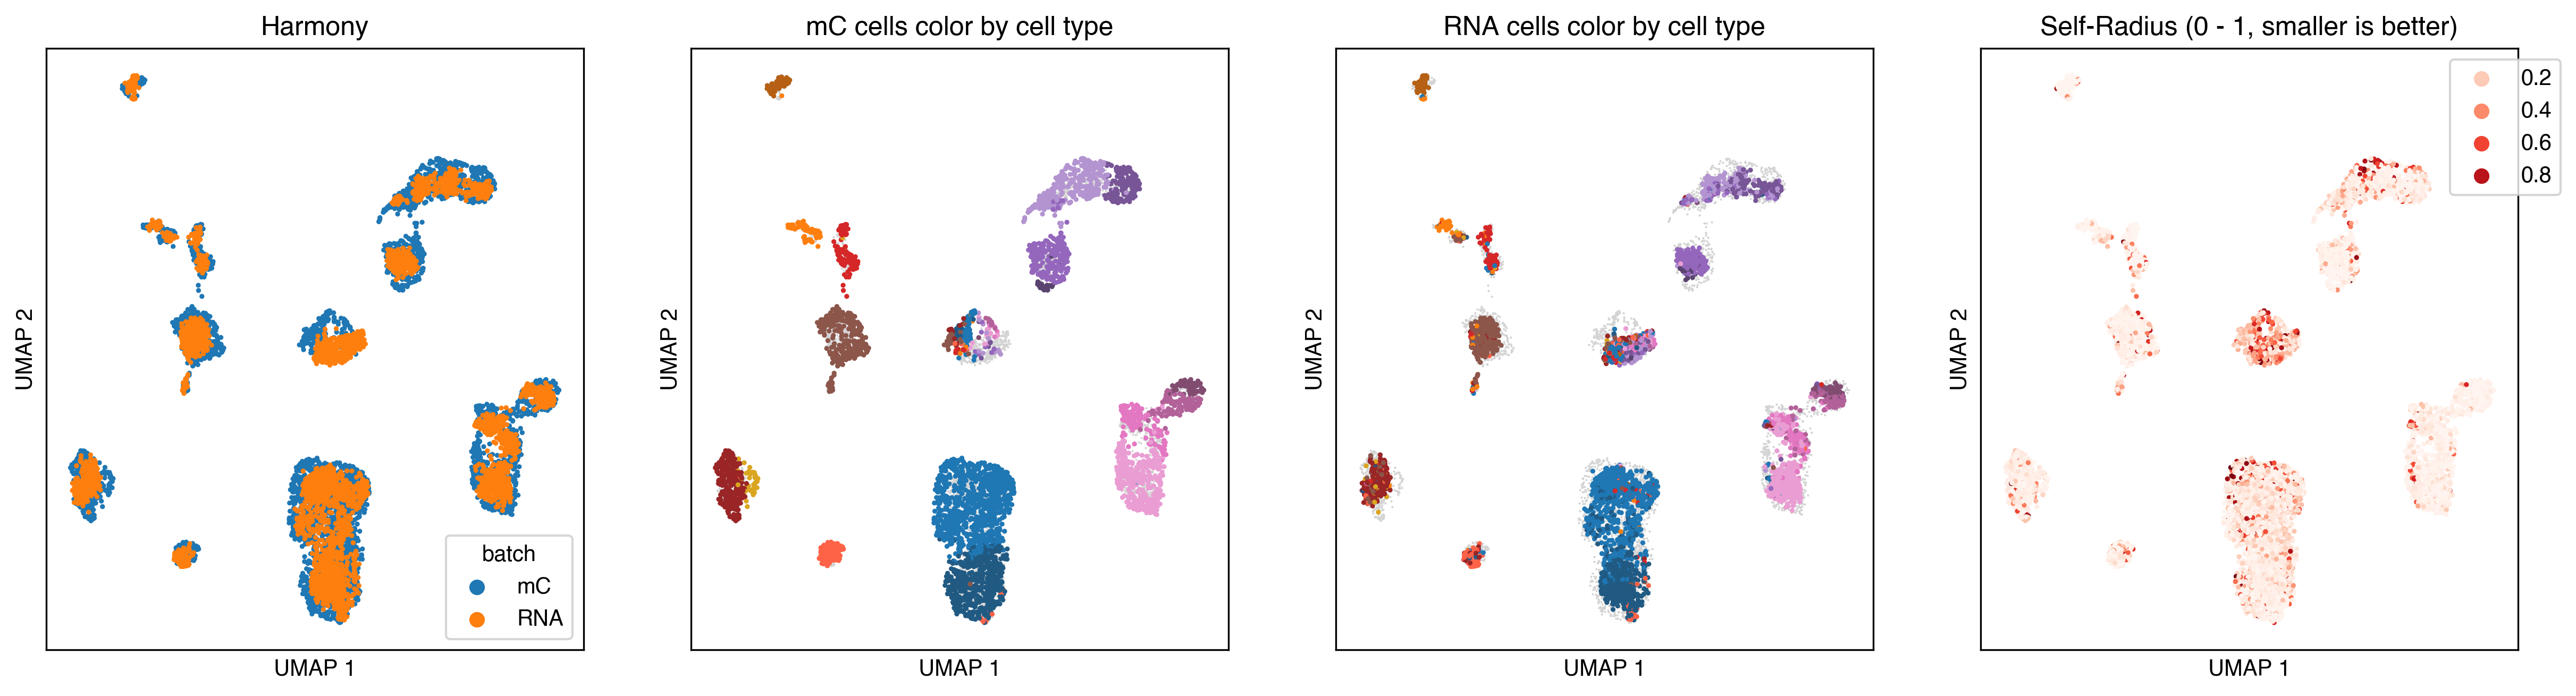

In [4]:
plot(harmony_adata, analysis_name='Harmony')

## Scanorama

In [6]:
scanorama_adata = anndata.read_h5ad('scanorama.Seurat_HVGs.2000hvg.h5ad')

In [7]:
#plot_batch(scanorama_adata, 'Scanorama')

In [8]:
self_radius = add_self_radius(scanorama_adata)
scanorama_adata.obs['self_radius'] = scanorama_adata.obs_names.str[:-4].map(self_radius).values

0
1000
2000
3000


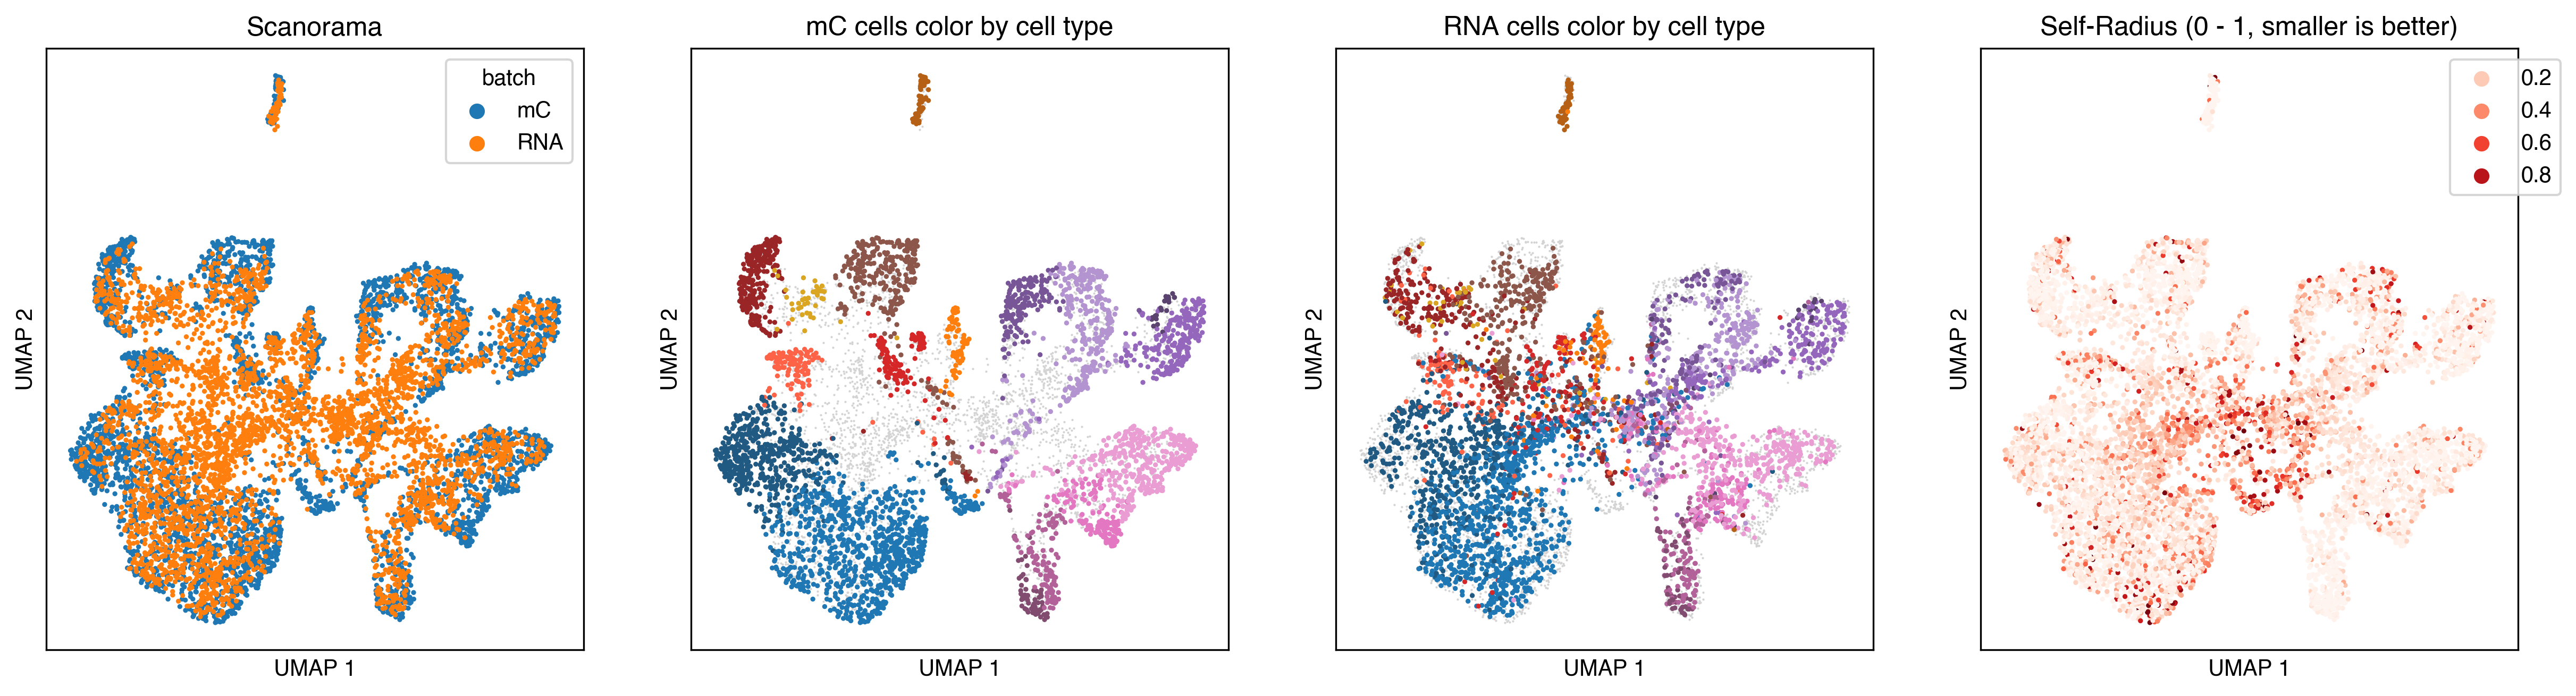

In [6]:
plot(scanorama_adata, analysis_name='Scanorama')

## Seurat

In [9]:
seurat_adata = harmony_adata.copy()

seurat_meta = pd.read_csv('../mCTN/dataset/ForSeurat/Metadata.csv.gz', index_col=0)
seurat_order = seurat_meta[seurat_meta['ClusterAnno'] != ''].index
seurat_index = pd.Index((seurat_order+'_mch').tolist() + (seurat_order+'_rna').tolist())
seurat_index = seurat_index[seurat_index.isin(seurat_adata.obs_names)]

pc = pd.read_hdf('Seurat.integrated.PCs.hdf')
pc.index = seurat_index
seurat_adata.obsm['X_pca'] = pc.reindex(seurat_adata.obs_names).values

umap = pd.read_hdf('Seurat.integrated.UMAP.hdf')
umap.index = seurat_index
seurat_adata.obsm['X_umap'] = umap.reindex(seurat_adata.obs_names).values
seurat_adata.obs['umap_0'] = seurat_adata.obsm['X_umap'][:, 0]
seurat_adata.obs['umap_1'] = seurat_adata.obsm['X_umap'][:, 1]

In [10]:
#plot_batch(seurat_adata, 'Seurat')

In [11]:
self_radius = add_self_radius(seurat_adata)
seurat_adata.obs['self_radius'] = seurat_adata.obs_names.str[:-4].map(self_radius).values

0
1000
2000
3000


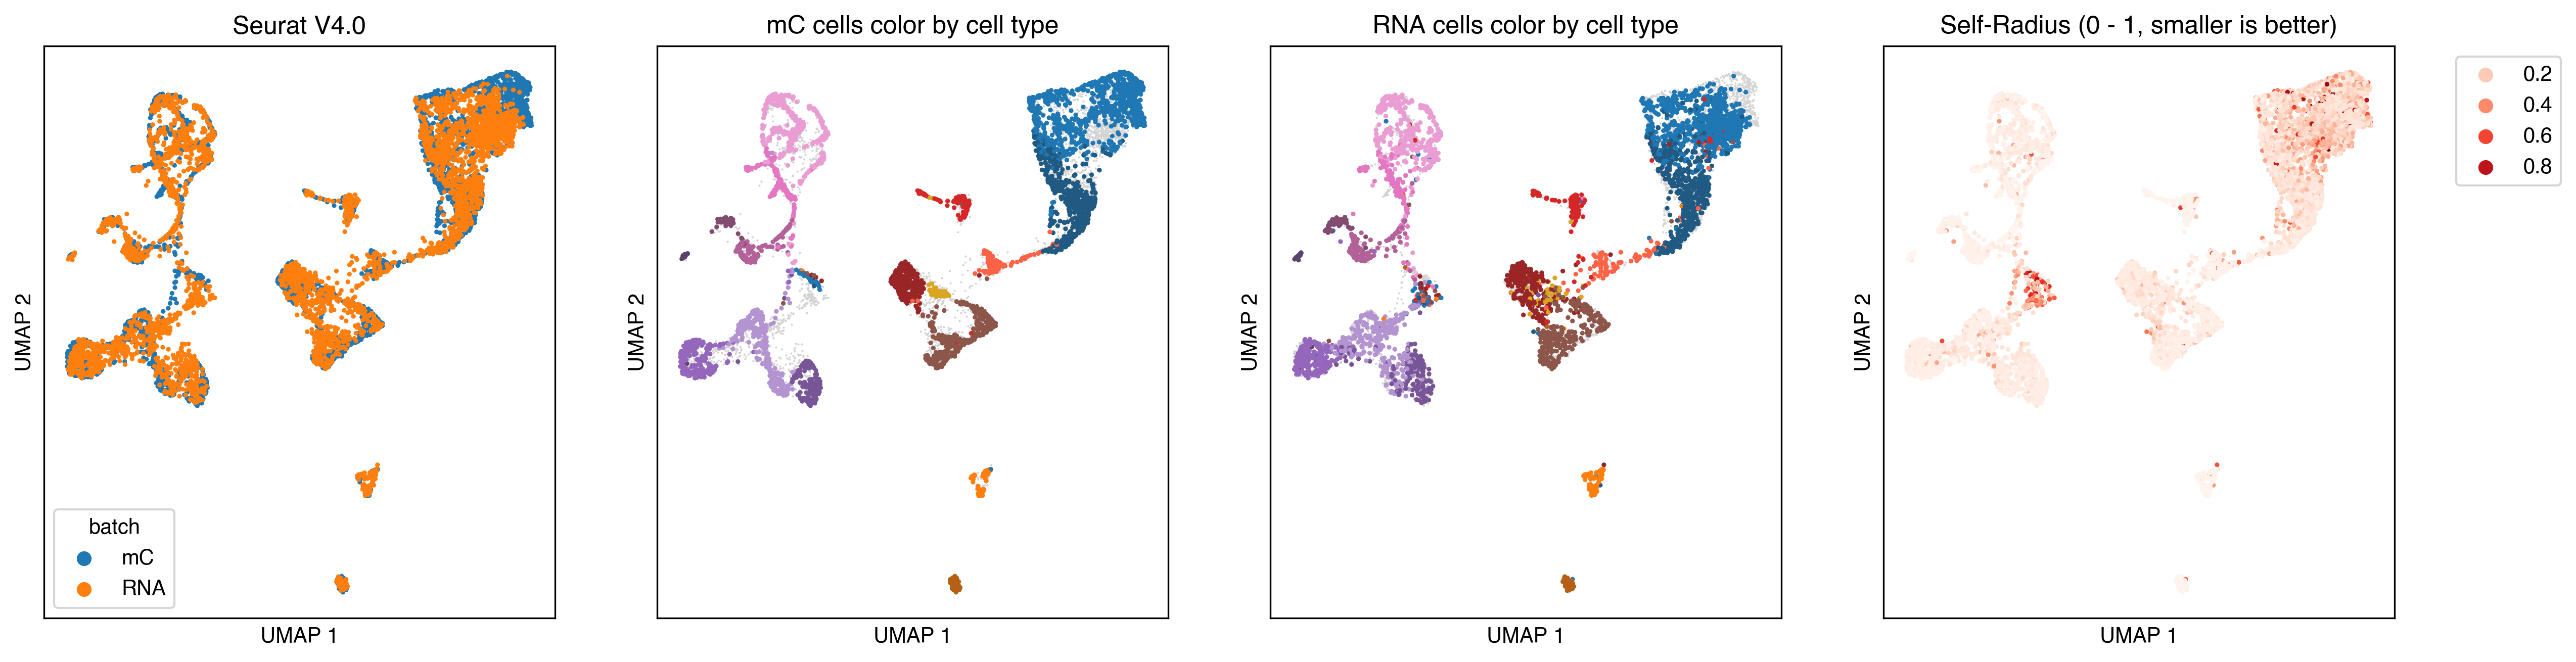

In [9]:
plot(seurat_adata, analysis_name='Seurat V4.0')

## LIGER

In [12]:
liger_adata = harmony_adata.copy()

pc = pd.read_csv('LIGER.H.norm.txt')
liger_adata.obsm['X_pca'] = pc.reindex(liger_adata.obs_names).values

sc.pp.neighbors(liger_adata)
sc.tl.leiden(liger_adata)
sc.tl.umap(liger_adata)

liger_adata.obs['umap_0'] = liger_adata.obsm['X_umap'][:, 0]
liger_adata.obs['umap_1'] = liger_adata.obsm['X_umap'][:, 1]

In [13]:
#plot_batch(liger_adata, 'LIGER')

In [14]:
self_radius = add_self_radius(liger_adata)
liger_adata.obs['self_radius'] = liger_adata.obs_names.str[:-4].map(self_radius).values

0
1000
2000
3000


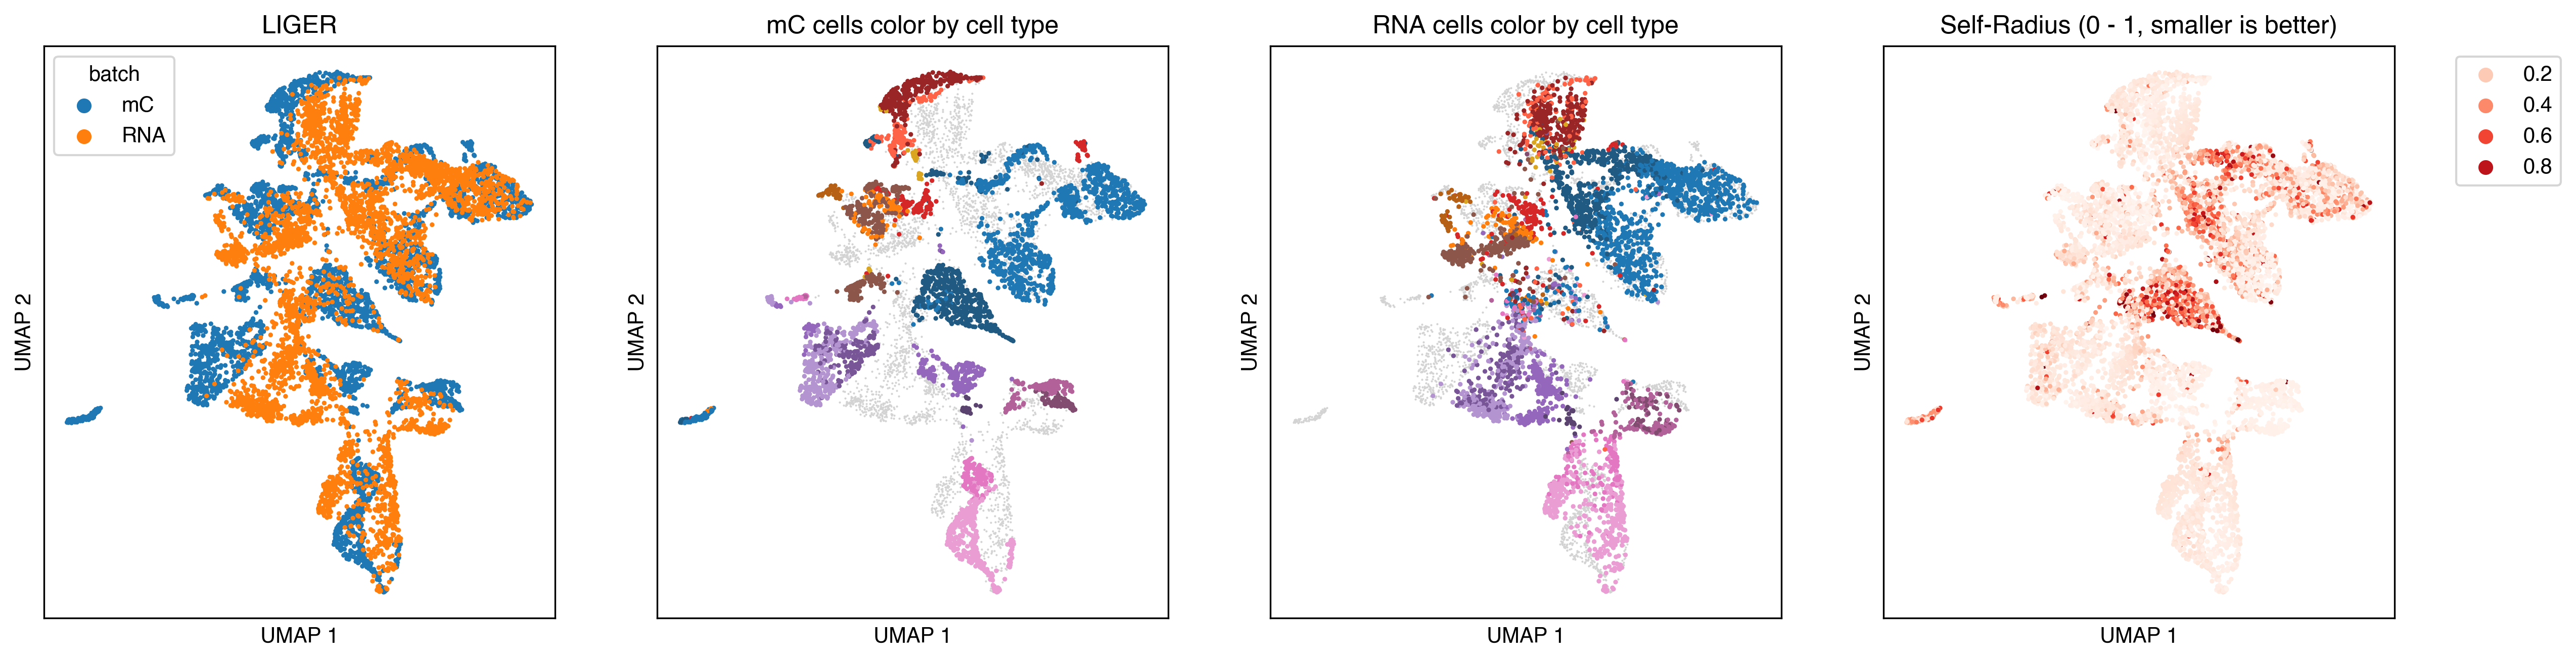

In [15]:
plot(liger_adata, analysis_name='LIGER')

## SCF

In [16]:
scf_adata = harmony_adata.copy()

scf_meta_mch = pd.read_csv('./input_archive/human_frontal_mch_metadata.tsv.gz', index_col=0, sep='\t')
scf_meta_rna = pd.read_csv('./input_archive/human_frontal_rna_metadata.tsv.gz', index_col=0, sep='\t')
scf_meta = pd.concat([scf_meta_mch, scf_meta_rna])

pc = np.load('pcX_all_human_mctseq_datav5_191001.npy')
scf_adata.obsm['X_pca'] = pc

sc.pp.neighbors(scf_adata, n_pcs=30)
sc.tl.leiden(scf_adata)
sc.tl.umap(scf_adata)

In [17]:
scf_adata.obs['umap_0'] = scf_adata.obsm['X_umap'][:, 0]
scf_adata.obs['umap_1'] = scf_adata.obsm['X_umap'][:, 1]

In [18]:
#plot_batch(scf_adata, 'SingleCellFusion')

In [19]:
self_radius = add_self_radius(scf_adata)
scf_adata.obs['self_radius'] = scf_adata.obs_names.str[:-4].map(self_radius).values

0
1000
2000
3000


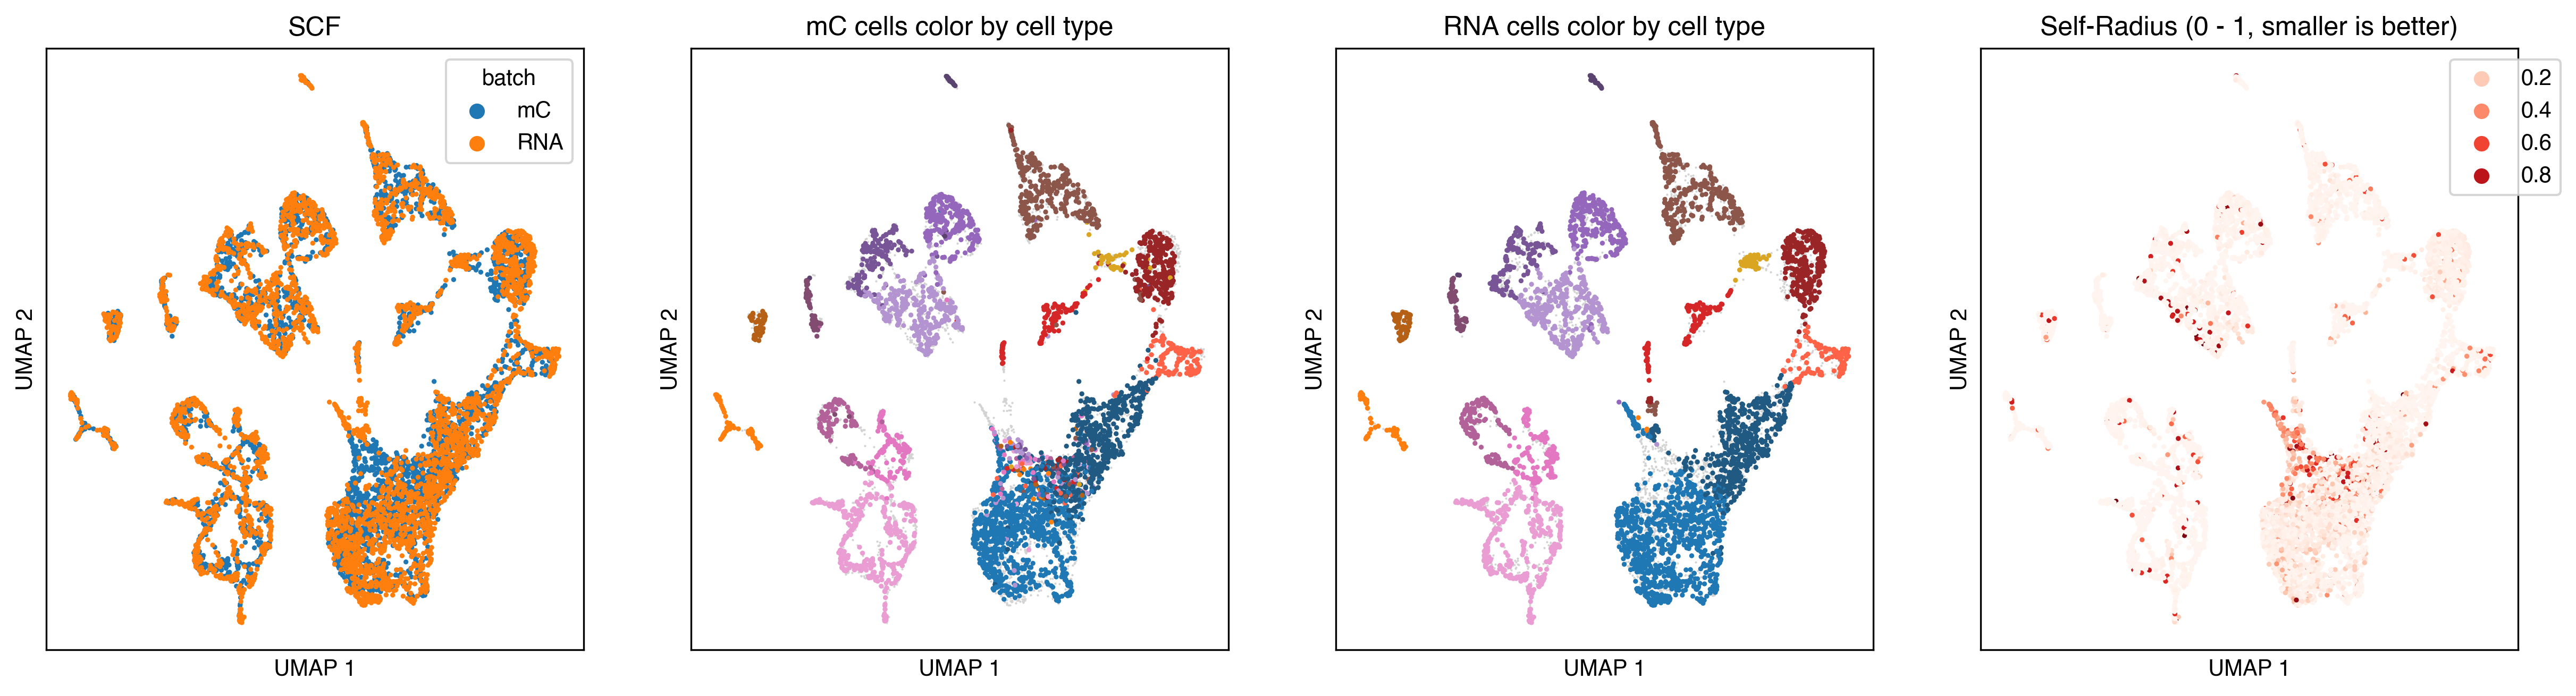

In [24]:
plot(scf_adata, analysis_name='SCF')

## Summary

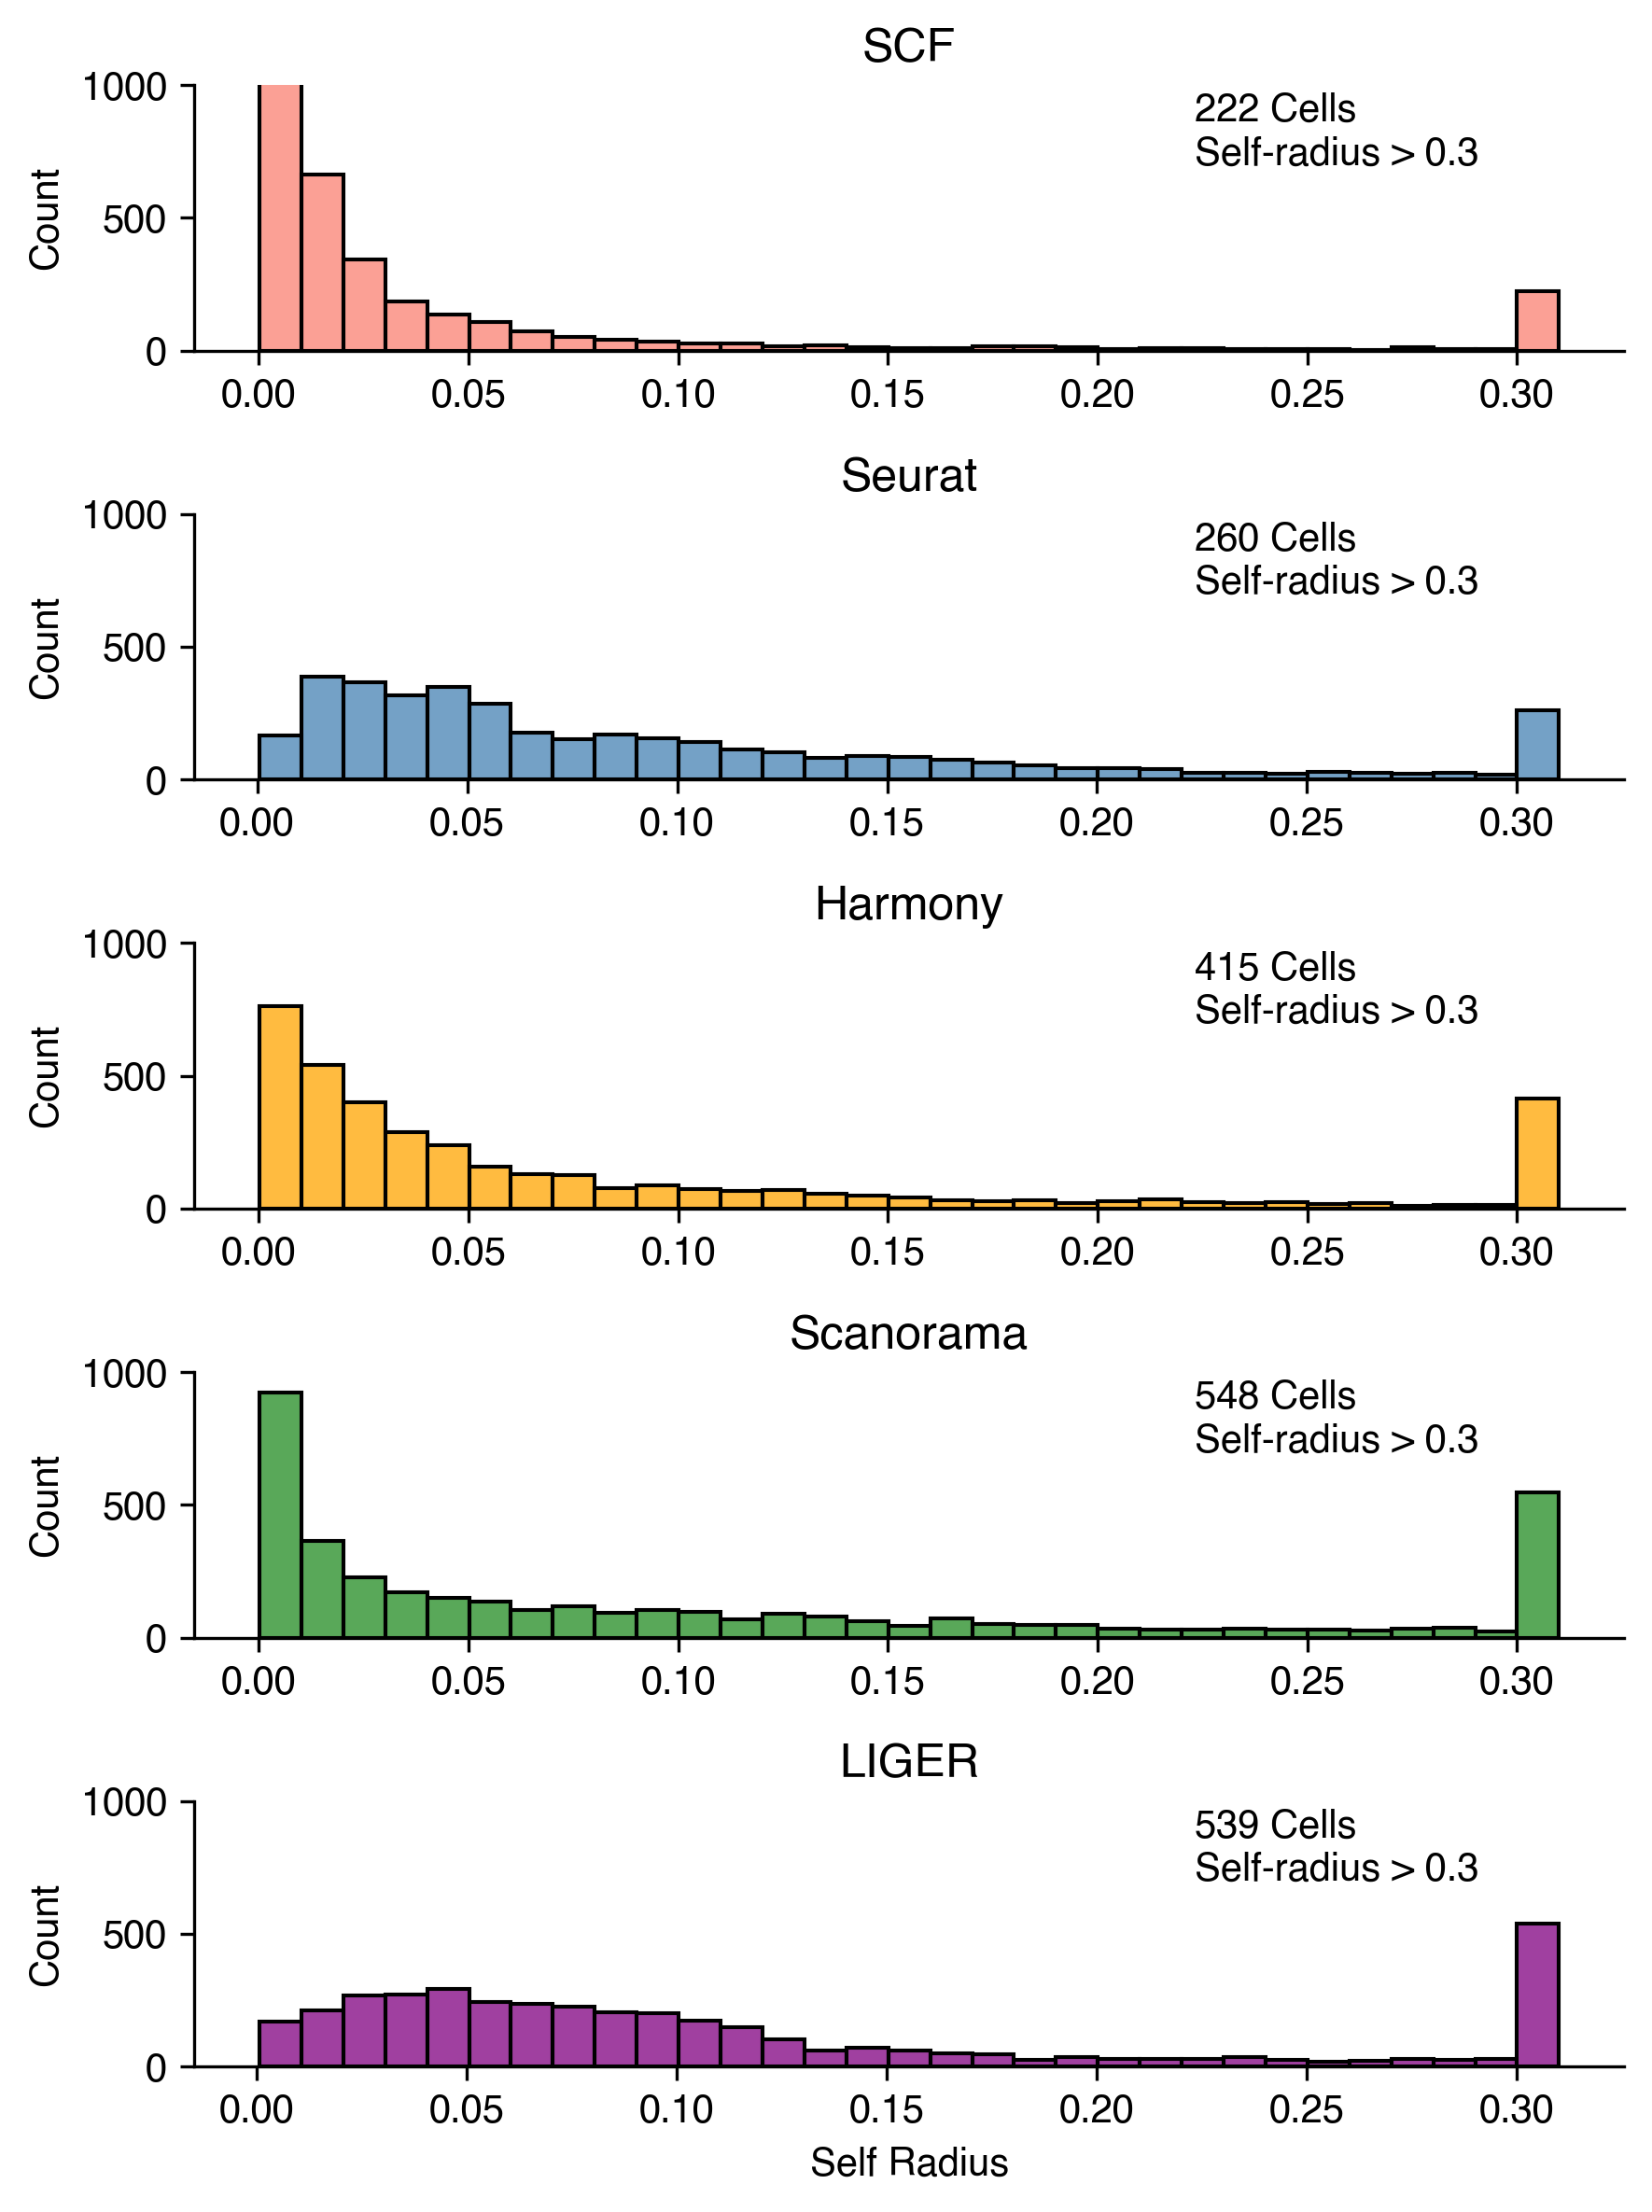

In [22]:
radius = pd.DataFrame({
    'Harmony': harmony_adata.obs['self_radius'],
    'Seurat': seurat_adata.obs['self_radius'],
    'SCF': scf_adata.obs['self_radius'],
    'Scanorama': scanorama_adata.obs['self_radius'],
    'LIGER': liger_adata.obs['self_radius']
})
radius = radius[radius.index.str.endswith('_mch')]
radius[radius > 0.31] = 0.31

fig, axes = plt.subplots(figsize=(6, 8), nrows=5, dpi=300)

ax = axes[0]
sns.histplot(ax=ax, data=radius['SCF'], color='salmon', bins=31)
ax.set(title='SCF', xlabel='', ylim=(0, 1000))
ax.text(0.7, 0.7, f"{int((radius['SCF'] > 0.29999).sum())} Cells\nSelf-radius > 0.3", transform=ax.transAxes)

ax = axes[1]
sns.histplot(ax=ax, data=radius['Seurat'], color='steelblue', bins=31)
ax.set(title='Seurat', xlabel='', ylim=(0, 1000))
ax.text(0.7, 0.7, f"{int((radius['Seurat'] > 0.29999).sum())} Cells\nSelf-radius > 0.3", transform=ax.transAxes)

ax = axes[2]
sns.histplot(ax=ax, data=radius['Harmony'], color='orange', bins=31)
ax.set(title='Harmony', xlabel='', ylim=(0, 1000))
ax.text(0.7, 0.7, f"{int((radius['Harmony'] > 0.29999).sum())} Cells\nSelf-radius > 0.3", transform=ax.transAxes)

ax = axes[3]
sns.histplot(ax=ax, data=radius['Scanorama'], color='forestgreen', bins=31)
ax.set(title='Scanorama', xlabel='', ylim=(0, 1000))
ax.text(0.7, 0.7, f"{int((radius['Scanorama'] > 0.29999).sum())} Cells\nSelf-radius > 0.3", transform=ax.transAxes)

ax = axes[4]
sns.histplot(ax=ax, data=radius['LIGER'], color='purple', bins=31)
ax.set(title='LIGER', xlabel='Self Radius', ylim=(0, 1000))
ax.text(0.7, 0.7, f"{int((radius['LIGER'] > 0.29999).sum())} Cells\nSelf-radius > 0.3", transform=ax.transAxes)

sns.despine(fig=fig)
fig.tight_layout()
fig.savefig('Self_radius.pdf')